In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import widgets, interactive
%matplotlib inline

In [2]:
df = pd.read_csv("../final_merge.csv") #import dataframe
df['album_release'] = df['album_release'].fillna(0).astype(int) #must fill nan with value to convert to int
df = df.loc[df['year'] != 0] #don't take 0, as it means unknown
df.describe()

,Unnamed: 0,song_hotttnesss,artist_latitude,artist_longitude,loudness_x,mode_x,tempo_x,key_x,genre2_cd2c,duration,...,mode_y,speechiness,acousticness,instrumentalness,liveness,valence,tempo_y,duration_ms,track_popularity,album_release
count,5.203790e+05,349099.000000,188960.000000,188960.000000,520379.000000,520379.000000,520379.000000,520379.000000,0.0,520379.000000,...,146243.0,219885.000000,219942.000000,175752.000000,219979.000000,219876.000000,219885.000000,2.199850e+05,219841.000000,520379.000000
mean,5.032707e+05,0.431690,39.934698,-54.412027,-9.693092,0.663566,124.785756,5.315261,NaN,246.792014,...,1.0,0.082549,0.283646,0.254747,0.224016,0.488946,121.642483,2.394201e+05,4.899527,845.338449
std,2.908924e+05,0.214983,15.701568,56.035174,4.938521,0.472490,34.854771,3.600813,NaN,115.333437,...,0.0,0.110330,0.327752,0.350219,0.203055,0.262209,29.419634,1.043991e+05,8.608010,988.505496
min,0.000000e+00,0.000000,-51.800580,-159.540540,-57.004000,0.000000,0.000000,0.000000,NaN,0.313020,...,1.0,0.021600,0.000001,0.000001,0.008600,0.000010,30.716000,4.000000e+03,0.000000,0.000000
25%,2.511270e+05,0.304170,35.149680,-90.180490,-12.167000,0.000000,99.002000,2.000000,NaN,183.196280,...,1.0,0.034400,0.007250,0.000175,0.097400,0.273000,98.943000,1.822930e+05,0.000000,0.000000
50%,5.030970e+05,0.459725,40.714550,-75.162370,-8.608000,1.000000,122.486000,5.000000,NaN,229.929340,...,1.0,0.045700,0.116000,0.016000,0.136000,0.486000,120.099000,2.274670e+05,0.000000,0.000000
75%,7.548480e+05,0.582811,50.848380,-1.546580,-6.124000,1.000000,145.256500,9.000000,NaN,286.980770,...,1.0,0.077400,0.538000,0.573000,0.292000,0.703000,139.709000,2.793070e+05,6.000000,2002.000000
max,1.007806e+06,1.000000,70.695760,178.690960,4.150000,1.000000,280.955000,11.000000,NaN,3024.665670,...,1.0,0.969000,0.996000,0.999000,1.000000,1.000000,246.830000,3.005613e+06,73.000000,2016.000000


We can see that we still have more than 500k tracks to do our year/time analysis, which should be enough to see correlations if there are any.

Text(0.5,0.9,'Samples per year')

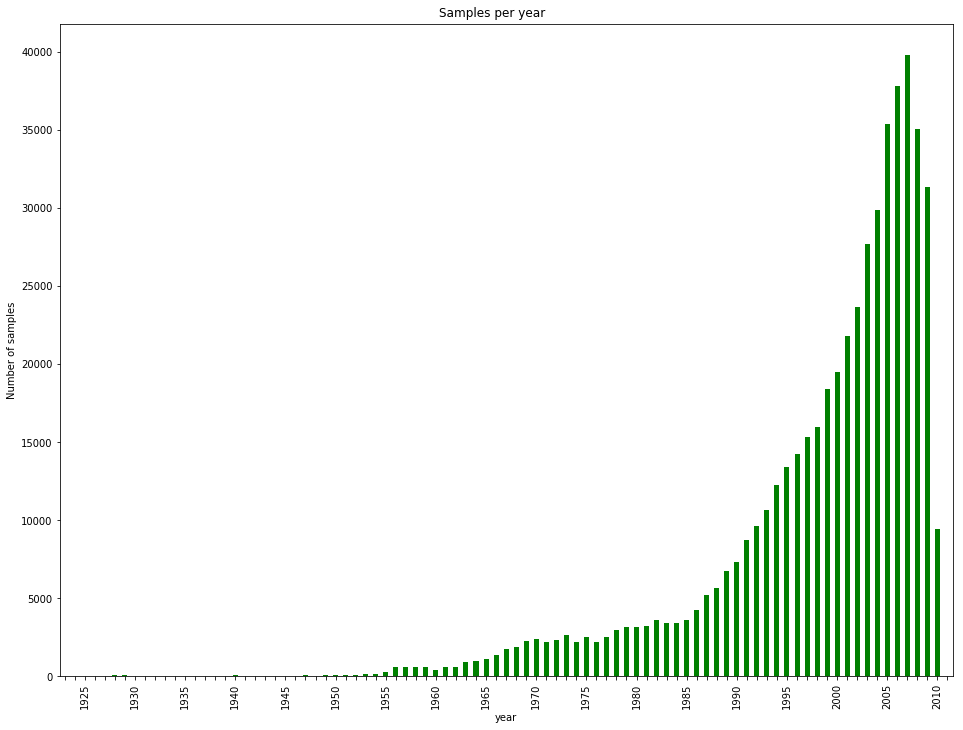

In [4]:
df_c = df.copy()

year_plot = df_c.groupby('year').size().plot(kind='bar', figsize=(16,12), color='g')
ax = plt.gca()
for label in ax.get_xticklabels(): #Little trick to avoid cluttering the x axis and only see every 5 years
    label.set_visible(False)
for label in ax.get_xticklabels()[2::5]:
    label.set_visible(True)
ax.set_ylabel("Number of samples")
fig = plt.gcf()
fig.suptitle("Samples per year", y=0.9)
#fig.savefig("../year_analysis_plots/samples_per_year.png", bbox_inches='tight')

## Analysis

We can see, as expected, that the dataset doesn't have many songs before ~1990. It also stops after 2010 (when the dataset got created). The set is therefore not sampled uniformly on the release date. Indeed, as explained on the MSD website, the dataset was chosen using the most popular artist / tracks, which explains why older songs are underrepresented.

In [5]:
sns.set(font_scale=1.75)
def plot_by(df, idx, column, ax=None):
    '''
        Plot a column (y axis) against an index (x axis)
        Will generate a plot matching for each idx value the mean of the column value for this idx.
        :param df: The dataframe containing the data
        :param idx: The x axis series
        :param column: the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type idx: string
        :type column: string
        :type ax: Axes
    '''
    df_c = df.copy()
    df_c = df_c[[idx,column]]
    if ax == None:
        axes = plt.gca()
    else:
        axes = ax
    axes.set_xlabel(idx)
    axes.set_ylabel(column)
    df_c.groupby([idx]).mean().plot(ax=ax)
    
def plot_by_year(df, column, ax = None):
    '''
        Plot a column (y axis) against the year (x axis)
        Will generate a plot matching for each year the mean of the column value for this year.
        :param df: The dataframe containing the data
        :param column: the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type column: string
        :type ax: Axes
    '''
    plot_by(df,'year',column, ax=ax)
    
def plot_heatmap_by(df, idx, column, ax = None):
    '''
        Plot a heatmap using an index (x axis), and a column (y axis)
        The color value of the heatmap will be the number of samples for this coordinate.
        :param df: The dataframe containing the data
        :param idx: the name of the x axis series
        :param column: the name of the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type idx: string
        :type column: string
        :type ax: Axes
    '''
    df_c = df.copy()
    df_c = df_c[[idx,column]]
    if df[column].dtype == np.float or df[column].dtype == np.float64: #Bin the data if needed
        bins = np.linspace(df[column].min(),df[column].max(),20)
        df_c[column] = pd.cut(df_c[column],bins)
    df_c = df_c.dropna()
    df_count = pd.DataFrame(df_c.groupby([idx, column]).size().rename('count'))
    df_c = df_c.join(df_count, on=[idx,column])
    df_c = df_c.reset_index().pivot_table(index=idx, columns=column, values='count', aggfunc='mean')
    if ax==None:
        axes = plt.gca()
    else:
        axes = ax
    axes.set_xlabel(idx)
    axes.set_ylabel(column)
    sns.heatmap(df_c, ax=ax, cbar_kws={'label': 'Number of samples'})

def plot_heatmap_by_year(df, column, ax=None):
    '''
        Plot a heatmap using a column (y axis) against the years
        The color value of the heatmap will be the number of samples for this coordinate.
        :param df: The dataframe containing the data
        :param column: the name of the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type column: string
        :type ax: Axes
    '''
    plot_heatmap_by(df, 'year', column, ax=ax)
    
def plot_for_year(df, column, year, ax=None, decade=False):
    '''
        Plot a stripplot (lineplot) of a feature / column for a given year against the song_hotttnesss
        The plot will have jitter to better visualize the data
        :param df: The dataframe containing the data
        :param column: the name of the series
        :param year: the year
        :param ax: A custom axis object to plot on
        :param decade: Whether to consider the whole decade or not
        :type df: DataFrame
        :type column: string
        :type year: int
        :type ax: Axes
        :type decade: boolean
    '''
    df_c = df.copy()
    if decade:
        df_c['year'], bins=pd.cut(df_c['year'],range(1960,2020,10), include_lowest=True, retbins=True)
        interval = pd.Interval(year, year+10)
        df_c = df_c[interval==df_c['year']]
    else:
        df_c = df_c[df_c['year']==year]
    df_c = df_c[[column, 'song_hotttnesss']]
    df_c['song_hotttnesss'], bins = pd.cut(df_c['song_hotttnesss'],np.linspace(0,1,11), retbins=True) #Bin the song hotness
    if ax == None:
        axes = plt.gca()
    else:
        axes = ax

    axes.set_xlim(df[column].min()-0.1,df[column].max()+0.1)
    axes.set_xlabel(column)
    axes.set_ylabel(year)
    sns.stripplot(x=column, y='song_hotttnesss',data=df_c, jitter=0.5, ax=axes)
    axes.invert_yaxis()
    min_y = axes.get_ylim()[0]
    max_y = axes.get_ylim()[1]
    length = max_y-min_y
    for hotness in df_c['song_hotttnesss'].unique(): #Plot the mean of each song hotness bin
        if type(hotness)==pd.Interval:
            median = df_c.loc[df_c['song_hotttnesss']==hotness][column].median()
            start = hotness.left
            end = hotness.right
            axes.plot([median,median], [length*start+min_y, length*end+min_y], color='k', zorder=1000)
    
    
def plot_heatmap_for_year(df, column1, column2, year, ax=None):
    '''
        Plot a kdeplot of two features / columns for a given year
        It will allow to see correlation between the two columns
        :param df: The dataframe containing the data
        :param column1: the name of the first series
        :param column2: the name of the second series
        :param year: the year
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type column1: string
        :type column2: string
        :type year: int
        :type ax: Axes
    '''
    df_c = df.copy()
    df_c = df_c[df_c['year']==year]
    df_c = df_c[[column1, column2]]
    df_c = df_c.dropna()
    if ax == None:
        axes = plt.gca()
    else:
        axes = ax
    axes.set_xlabel(column1)
    axes.set_ylabel(column2)
    sns.kdeplot(df_c[column1], df_c[column2], cmap="Reds", shade=True, shade_lowest=False, ax=axes)

def ceil(x):
    '''
        Shortcut for np.ceil(x).astype(int)
        :param x: the value to ceil
        :type x: number
        :return: The result of the ceiling as an int
        :rtype: int
    '''
    return np.ceil(x).astype(int)

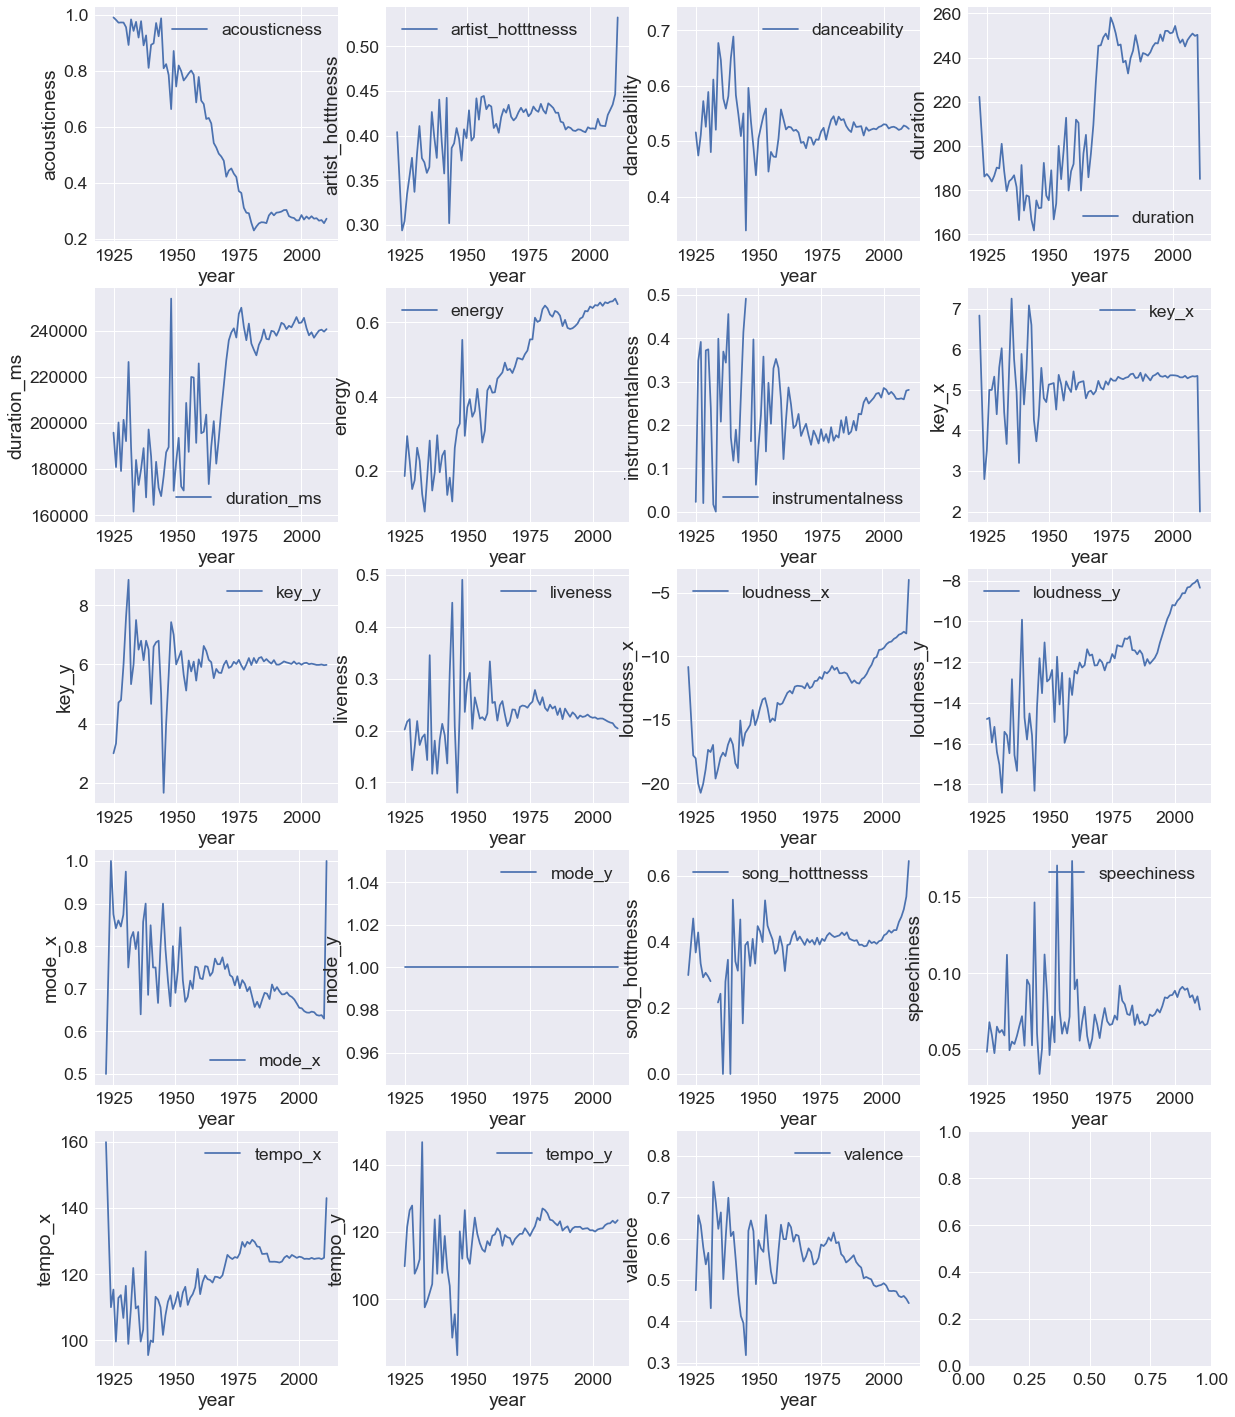

In [6]:
selected = ['song_hotttnesss', 'loudness_x', 'mode_x', 'tempo_x', 'key_x', 'duration', 'artist_hotttnesss', 'danceability', 'energy', 'key_y', 'loudness_y', 'mode_y', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms']
selected.sort()

n_cols = 4
n_rows = ceil(len(selected)/n_cols)
fig, ax = plt.subplots(n_rows,n_cols)
fig.set_size_inches(20,n_rows*20/n_cols)
idx_r = 0
idx_c = 0

#For each feature, plot the mean of the feature for each year
for col in selected:
    plot_by_year(df,col,ax=ax[idx_r, idx_c])
    if idx_c==n_cols-1:
        idx_r+=1
        idx_c=0
    else:
        idx_c+=1

## Analysis

For most of the data before ~1960, there is a huge variance due to the low number of samples. However, we can still see tendencies for several features.    
- Duration : We can see a clear spike (for both duration and duration_ms) around 1960. We suppose that it is due to the apparition and democratization of the vinyl record (more precisely its more modern iteration). This allowed the musicians to store longer musics (which seemed to be a problem before). However, the duration hasn't increased since, probably because the artists and public feel that the current mean duration is the most optimal one.

- Acousticness : We see a massive drop through the years. This is surely due to the apparition of the electronic music (acousticness is determined by the absence of electronic instruments).

- Loudness : The music seems to get louder and louder. This is probably due to cultural changes (genre, etc).

- Energy : The energy also increases along with the loudness.

- Song hotness : The hotness seems to spike at around 2010. This may be explained by the algorithm, if it is similar to the one of Spotify, the hotness is hugely influenced by the recency of the music, which explains this result. Otherwise, this may be due to the same problem seen with tempo, mode, etc, which all spike at the end of the graph.

- We can drop mode_y, as it is always 1.

- We can't really say much about the other values, except that they seem to stay stable through the years.

In [ ]:
n_cols = 1
selected = ['song_hotttnesss', 'loudness_x', 'mode_x', 'tempo_x', 'key_x', 'duration', 'artist_hotttnesss', 'danceability', 'energy', 'key_y', 'loudness_y', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms']
n_rows = ceil(len(selected)/n_cols)
fig, ax = plt.subplots(n_rows,n_cols)
fig.set_size_inches(20,n_rows*20/n_cols/2) #Trying to find a good aspect
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)

#For each feature, print the heatmap of the feature regarding the year
for idx,col in enumerate(selected):
    plot_heatmap_by_year(df, col, ax=ax[idx])

## Analysis
These graphs don't show much, except that most of the samples are recent, as seen earlier (and what feature values those recent years samples have). We could perhaps normalize by year to have a better visualization.

In [ ]:
n_cols = 2
year_r = range(1960,2012)
n_rows = np.ceil(len(year_r)/n_cols).astype(int)
#fig, ax = plt.subplots(n_rows,n_cols)
#fig.set_size_inches(20,n_rows/n_cols*20)
idx_r = 0
idx_c = 0

#Plot the song hotness distribution for each year
#for year in year_r:
#    plot_for_year(df,'song_hotttnesss',year,ax=ax[idx_r, idx_c])
#    if idx_c==n_cols-1:
#        idx_r+=1
#        idx_c=0
#    else:
#        idx_c+=1

## Analysis example

The first thing we remark is that a lot of the samples have an hotness of 0. We wondered if this means that the song hasn't been rated, but the description of the dataset just says that the hotness goes from 0 to 1, thus it seems that those songs are just really unpopular (which seems plausible).

We can see that, although the number of samples drastically increases as time goes on, the distribution roughly stays the same (which we could see in the previous graphs). We can also distinguish what looks like lines around 0.2, 0.27, 0.3 mainly (which means an higher concentration of samples). We don't know if it is due to the algorithm used for the rating or if this is just a coincidence at the moment.

### You will need the ipython extensions / widgets enabled to use the interactive graph below

In [ ]:
df_c = df.copy()
df_c = df_c[df_c['year']>=1960] #Only take after 1960, as before there are very few samples
DECADE = "Decade"
SINGLE_YEAR = "Single year"
df_c['artist_hotttnesss'][df_c['artist_hotttnesss']<0]=0 # Clamp the artist hotness as the data is sometimes faulty
df_c['artist_hotttnesss'][df_c['artist_hotttnesss']>1]=1
decades = widgets.RadioButtons( #Button to select year or decade
options=[DECADE,SINGLE_YEAR],value=SINGLE_YEAR, disabled=False, description="Year grouping")
year = widgets.BoundedIntText( #Field to select year
    value=1960,
    min=1960,
    max=2010,
    step=1,
    description='Year:',
    disabled=False,
    color='black'
)
def update_year(*args):
    """
    Update the year widget depending on the button value
    """
    if decades.value==SINGLE_YEAR:
        year.step=1
        year.max=2010
        year.description='Year:'
    else:
        year.step=10
        year.value=np.round(year.value/10)*10
        year.max=2000
        year.description="Decade:"
    
decades.observe(update_year,'value') #Listener

feature = widgets.Dropdown( #Widget to select the feature
    options=selected[1:], #Don't take song hotness
    value='loudness_x',
    description='Feature:',
)

def save_all_plots():
    """
    Saves all the year stripplots
    """
    for f in selected[1:]:
        for year in range(1960, 2011):
            plotit(f, year, SINGLE_YEAR)
            fig = plt.gcf()
            fig.savefig("../year_analysis_plots/single_year/"+f+"_"+str(year)+".png", bbox_inches='tight')
            if year<2010 and year%10==0: #Save the decades too
                plotit(f,year,DECADE)
                fig = plt.gcf()
                fig.savefig("../year_analysis_plots/decade/"+f+"_"+str(year)+"-"+str(year+10)+".png",bbox_inches="tight")
            
def plotit(feature, year, decades):
    df_d = df_c.copy()
    plt.clf()
    fig = plt.gcf()
    fig.set_size_inches(16,16)
    decade = decades==DECADE
    ax = plt.gca()
    if decade:
        title = str(year)+" - "+str(year+10)
    else:
        title = str(year)
    fig.suptitle(title, y=0.9)
    plot_for_year(df_d,feature,year, decade=decade)

interactive(plotit,feature=feature, year=year, decades = decades)
# save_all_plots()

## Analysis
The analysis will be done by decade, as otherwise the values per year jump a lot, and grouping by decade helps to visualize better the evolution of the features (their tendency). To avoid cluttering the notebook, the plots have been saved and examined on the disk (they are also available on the github repository).

### Features
First off, the features don't seem to influence the song hotness at all (except for the artist hotness obviously), which is a bit of a letdown. The median for each song hotness bin seems to be around the same value, and the distributions the same.

### Evolution
There are some evolutions through the years / decades though:
- The acousticness seems to decrease throughout the years, and the mean acousticness is quite low overall.
- The duration increased from the 60s to the 70s, and then stayed at ~250s.
- The songs become more and more energetic decade after decade.
- The loudness also increases with the decades. The top songs seems to be louder as well.
- The valence decreases with the time, and the top songs hang around 0.5 valence.

## Conclusion
We can't really see any link between a feature through the years and the song hotness. We also can't, for most of the features, see any real evolution. These problems are maybe due to the selection bias of the MSD.

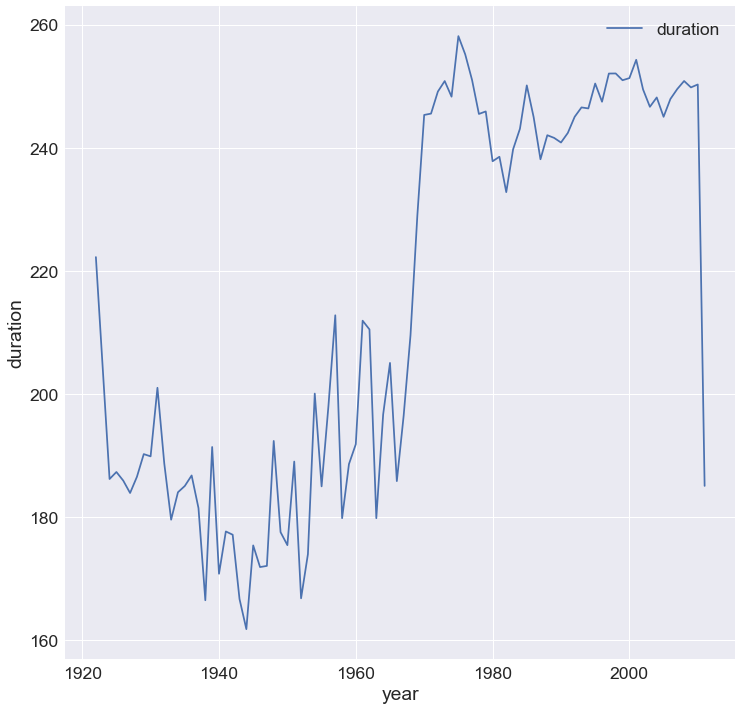

In [11]:
fig = plt.figure()
fig.set_size_inches(12,12)
ax = plt.gca()
plot_by_year(df,"duration",ax=ax)
fig.savefig("../datastory/figures/year_analysis_plots/duration.png")